In [1]:
import numpy as np
import pandas as pd
from scipy.stats import gaussian_kde
from scipy.spatial.distance import squareform
from scipy.interpolate import griddata

from rdkit import Chem
from rdkit.Chem import Descriptors

from tdc.single_pred import ADME, Tox

from sklearn.manifold import MDS

from rogi import RoughnessIndex

import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.pyplot as plt
from matplotlib import cm

sns.set(style='ticks')

In [5]:
# ------------------------
# TDC regression datasets
# ------------------------
adme_props = [('Caco2_Wang', None), 
              ('Lipophilicity_AstraZeneca', None), 
              ('Solubility_AqSolDB', None), 
              ('HydrationFreeEnergy_FreeSolv', None), 
              ('PPBR_AZ', None), 
              ('VDss_Lombardo', None),
              ('Half_Life_Obach', None), 
              ('Clearance_Hepatocyte_AZ', None), 
              ('Clearance_Microsome_AZ', None)]

tox_props = [('LD50_Zhu', None),
             ('herg_central', 'hERG_at_1uM'), 
             ('herg_central', 'hERG_at_10uM')]


# combine
props = []
props.extend(adme_props)
props.extend(tox_props)

# property labels
props_labels = ['Caco-2 permeability (cm/s)',
                'Lipophilicity (LogP)',
                'Aqeuous solubility\n' + r'$(log(mol/L))$',
                r'$\Delta G_{hydr}$ (kcal/mol)',
                'Plasma protein binding (%)',
                'VDss (L/Kg)',
                r'Half life ($h$)',
                'Hepatocyte clearance\n' + r'$(\mu L \times min^{-1} \times (10^6 cells)^{-1} ) $',
                'Microsome clearance\n' + r'$(mL \times min^{-1} \times g^{-1} ) $',
                'Acute Toxicity, LD50\n' + r'$(log[1/(mol/kg)])$',
                'hERG inhibition\nat ' + f'$1\ \mu M$' + ' (%)',
                'hERG inhibition\nat ' + f'$10\ \mu M$' + ' (%)']


# def func to get TDC dataset
def get_tdc_dataset(name, label_name):
        
    if (name, label_name) in adme_props:
        df = ADME(name=name, label_name=label_name).get_data()
    elif (name, label_name) in tox_props:
        df = Tox(name=name, label_name=label_name).get_data()
    else:
        raise ValueError(f'Cannot understand {name}, {label_name}')
        
    # subsample
    if len(df) > 10000:
        df = df.sample(n=10000, random_state=42)
    
    return df


def smiles_to_descriptors_df(smiles, descriptors=None):
    Xdict = {}
    mols = [Chem.MolFromSmiles(smi) for smi in smiles]
    for desc in Descriptors.descList:
        name = desc[0]
        f = desc[1]

        if descriptors is not None and name in descriptors:
            Xdict[name] = [f(m) for m in mols]
    return pd.DataFrame(Xdict)


# select some commonly-used descriptors
desc_names = ['MolWt', 'FractionCSP3', 'NumHAcceptors', 'NumHDonors', 'NOCount', 'NHOHCount',
              'NumAliphaticRings', 'NumAliphaticHeterocycles', 'NumAromaticHeterocycles', 'NumAromaticRings', 
              'NumRotatableBonds', 'TPSA', 'qed', 'MolLogP']

In [22]:
# ----------------
# PREPARE DATASET
# ----------------

prop_idx = 8
name = props[prop_idx][0]
label_name = props[prop_idx][1]
prop_label = props_labels[prop_idx]

data = get_tdc_dataset(name=name, label_name=label_name)
smiles = data.loc[:, 'Drug']
Y = data.loc[:, 'Y']

print(f"{name}, {label_name} ({len(Y)} molecules)")
    
# descriptors
df_X = smiles_to_descriptors_df(smiles, descriptors=desc_names)
X = df_X.to_numpy()
_X = (X - X.min(axis=0)) / (X.max(axis=0) - X.min(axis=0))

# compute RI score
rogi = RoughnessIndex(X=_X, Y=Y, metric='euclidean', verbose=False)
rogi_score = rogi.compute_index()
print(f"ROGI = {rogi_score:.2f}")

Found local copy...
Loading...
Done!


Clearance_Microsome_AZ, None (1102 molecules)
ROGI = 0.50


## 3D plot

In [23]:
def plot3d(Dx, ax, prop_label="", rccounts=100):

    print("projecting on 2D plane...")
    mds = MDS(n_components=2, dissimilarity='precomputed', random_state=42)
    X_2d = mds.fit_transform(squareform(Dx))

    # get x,y,z for 3D plot
    x = X_2d[:, 0]
    y = X_2d[:, 1]
    z = Y

    # property max/min
    vmin = np.min(z)
    vmax = np.max(z)

    # get interpolation
    dx = 1000j
    grid_x, grid_y = np.mgrid[x.min():x.max():dx, y.min():y.max():dx]
    grid_z = griddata(X_2d, z, (grid_x, grid_y), method='linear', rescale=True)

    # plot in 3D
    print("plotting...")
    masked_grid_z = np.ma.masked_invalid(grid_z)

    cmap = cm.get_cmap("coolwarm")
    colors = (masked_grid_z - vmin) / (vmax-vmin)
    facecolors = cmap(colors)

    ax.plot_surface(grid_x, grid_y, masked_grid_z, rcount=rccounts, ccount=rccounts, 
                color='b', alpha=0.75, linewidth=0, edgecolors='w', zorder=10,
                facecolors=facecolors, vmin=vmin, vmax=vmax)


    ax.set_xlabel(r'$z_1$', labelpad=8)
    ax.set_xlim(x.min(), x.max())
    ax.set_ylabel(r'$z_2$', labelpad=8)
    ax.set_ylim(y.min(), y.max())
    ax.set_zlabel('Z')
    ax.set_zlim(z.min(), z.max())

    ax.view_init(45, -60)

    ax.set_zlabel(prop_label, labelpad=12)
    ax.dist = 11

    return X_2d

projecting on 2D plane...
plotting...


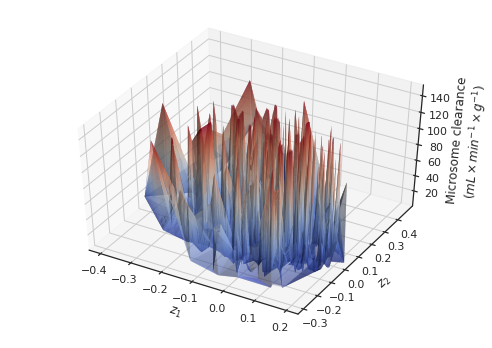

In [24]:
fig = plt.figure(figsize=(7,5))
ax = fig.gca(projection='3d')
X_2d = plot3d(Dx=rogi._Dx, ax=ax, prop_label=prop_label, rccounts=1000)  # use rccounts=1000 for high res images

plt.tight_layout()
fig.savefig(f"landscapes/3d-landscape-{name}.png", dpi=1200, bbox_inches='tight')

## 2D Plot

In [27]:
def plot2d(X, z, ax=None, interpolation='linear', nlevels=8, scatter=False, density=True, cbar=False, 
         cont_lw=0.75, cont_ls='solid', cont_colors='k', scatter_edgecolor='k', scatter_alpha=0.5,
         cmap='RdBu', vmin=None, vmax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(8,6))

    # Interpolate and generate heatmap:
    x = X[:, 0]
    y = X[:, 1]

    grid_x, grid_y = np.mgrid[x.min():x.max():1000j, y.min():y.max():1000j]    
    grid_z = griddata(X, z, (grid_x, grid_y), method=interpolation, rescale=True)
    
    #g = ax.pcolormesh(grid_x, grid_y, np.ma.masked_invalid(grid_z), cmap='Greens_r', vmin=np.nanmin(grid_z), vmax=np.nanmax(grid_z))
    if vmin is None:
        vmin = np.nanmin(grid_z)
    if vmax is None:
        vmax = np.nanmax(grid_z)
    
    g = ax.contourf(grid_x, grid_y, np.ma.masked_invalid(grid_z), levels=nlevels, cmap=cmap, vmin=vmin, vmax=vmax, alpha=1)
    
    contours = ax.contour(grid_x, grid_y, np.ma.masked_invalid(grid_z), nlevels, colors=cont_colors, linewidths=cont_lw, linestyles=cont_ls)
    
    if scatter is True:
        ax.scatter(x, y, s=20, color='none', linewidth=0.5, edgecolor=scatter_edgecolor, alpha=scatter_alpha, zorder=10)

    if density is True:
        _reference_colors = [[1.,1.,1.,0.], [1.,1.,1.,0.9]]
        _cmap = LinearSegmentedColormap.from_list('white', _reference_colors)
        _cmap_r = LinearSegmentedColormap.from_list('white_r', _reference_colors[::-1])
        
        # add density as white shade
        kde = gaussian_kde(dataset=np.array([x, y]), bw_method=None)
        density = kde(np.c_[grid_x.flat, grid_y.flat].T).reshape(grid_x.shape)
        cset = ax.contourf(grid_x, grid_y, density, cmap=_cmap_r, vmin=np.nanmin(density), vmax=np.nanmax(density))

    ax.axis('off')

    if cbar is True:
        _ = fig.colorbar(g)
        
    return g

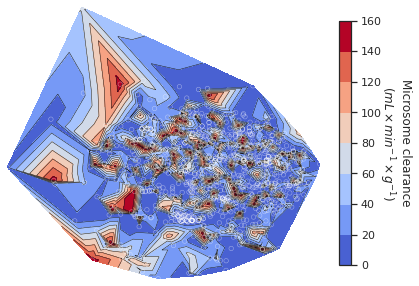

In [30]:
fig, ax = plt.subplots(figsize=(7,5))

g = plot2d(X_2d, z=Y, ax=ax, interpolation='linear', nlevels=8, scatter=True, density=False, cbar=False, cont_lw=0.5, 
     cmap='coolwarm', vmin=np.min(Y), vmax=np.max(Y),
     scatter_edgecolor='w', scatter_alpha=0.5,)

cbar = fig.colorbar(g, shrink=0.9)
cbar.set_label(prop_label, rotation=270, labelpad=30)

fig.savefig(f"landscapes/2d-landscape-{name}.png", dpi=1200, bbox_inches='tight')